# Interacting with Amazon Nova-Lite with images

## Context

Amazon Nova Lite is a very low-cost multimodal model that is lightning fast for processing image, video, and text inputs to generate text output. Amazon Nova Lite can handle real-time customer interactions, document analysis, and visual question-answering tasks with high accuracy. The model processes inputs up to 300K tokens in length and can analyze multiple images or up to 30 minutes of video in a single request. Amazon Nova Lite also supports text and multimodal fine-tuning and can be optimized to deliver the best quality and costs for your use case with techniques such as model distillation.

Please see [Amazon Nova User Guide](https://docs.aws.amazon.com/nova/latest/userguide/what-is-nova.html) for more details on Nova model variants & their capabilities.


In this notebook, we will provide an image **"animal.jpg"** to the Nova Lite model with model identifier **"us.amazon.nova-lite-v1:0"** together with a text query asking about what is in the image. To do this, we will package the image and text into the **MessagesAPI** format and utilize the **invoke_model** function from **bedrock-runtime** within our helper function defined below to generate a response from Nova Lite.


## Setup Dependencies

This notebook uses boto3 module


In [70]:
%pip install --upgrade pip
%pip install boto3 --upgrade --quiet
%pip install botocore --upgrade --quiet


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Restart the kernel to use installed dependencies


In [71]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Import Packages

1. Import the necessary libraries for creating the **bedrock-runtime** needed to invoke foundation models, formatting our JSON bodies, and converting our images into base64 encoding


In [72]:
import boto3
import json
import base64
from PIL import Image


bedrock_client = boto3.client('bedrock-runtime',region_name='us-west-2')


## Build Helper Functions

These helper functions read images, encode them to base64, prepare payload following Nova supported format and invoke the model


In [73]:
MODEL_ID = 'us.amazon.nova-lite-v1:0'


def read_and_encode_image(image_path, message_prompt):
    """
    Reads an image from a local file path and encodes it to a data URL.
    """
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
        
    base64_encoded = base64.b64encode(image_bytes).decode('utf-8')
    # Determine the image format (supported formats: jpg, jpeg, png, gif, webp)
    image_format = Image.open(image_path).format.lower()

    message_content = {
                    "image": {
                        "format": image_format,
                        "source": {"bytes": base64_encoded},
                    }
                }
    
    return message_content


def send_images_to_model(system_prompt: str, image_list: list):
    """
    Sends images and a prompt to the model and returns the response in plain text.
    """
    content_list = []
    for img in image_list:
        message_content = read_and_encode_image(img['image_path'], img['message_prompt'])
        content_list.append(message_content)
        content_list.append({'text': img['message_prompt']})
    

    system_list = [ { "text": system_prompt } ]
    # Define a "user" message including both the image and a text prompt.
    messages = [
        {
            "role": "user",
            "content": content_list,
        }
    ]

    # Configure the inference parameters.
    inf_params = {"max_new_tokens": 500, "top_p": 0.1, "top_k": 20, "temperature": 1.0}

    payload = {
        "schemaVersion": "messages-v1",
        "messages": messages,
        "system": system_list,
        "inferenceConfig": inf_params,
    } 
    
    response = bedrock_client.invoke_model(modelId=MODEL_ID, body=json.dumps(payload))
    
    model_response = json.loads(response["body"].read())
    
    # Print Response
    content_text = model_response["output"]["message"]["content"][0]["text"]
    print("\n[Response Content Text]")
    print(content_text)

    # Print Token Usage
    print('\n\n - Response Stats - ')
    print(f' Input Tokens: {model_response["usage"]["inputTokens"]}')
    print(f' Output Tokens: {model_response["usage"]["outputTokens"]}')
    print(f' Total Tokens: {model_response["usage"]["totalTokens"]}')

    return content_text
    


## Usage Examples

### Describe Image

In this use case, we provide an image of penguins and ask model to describe it.

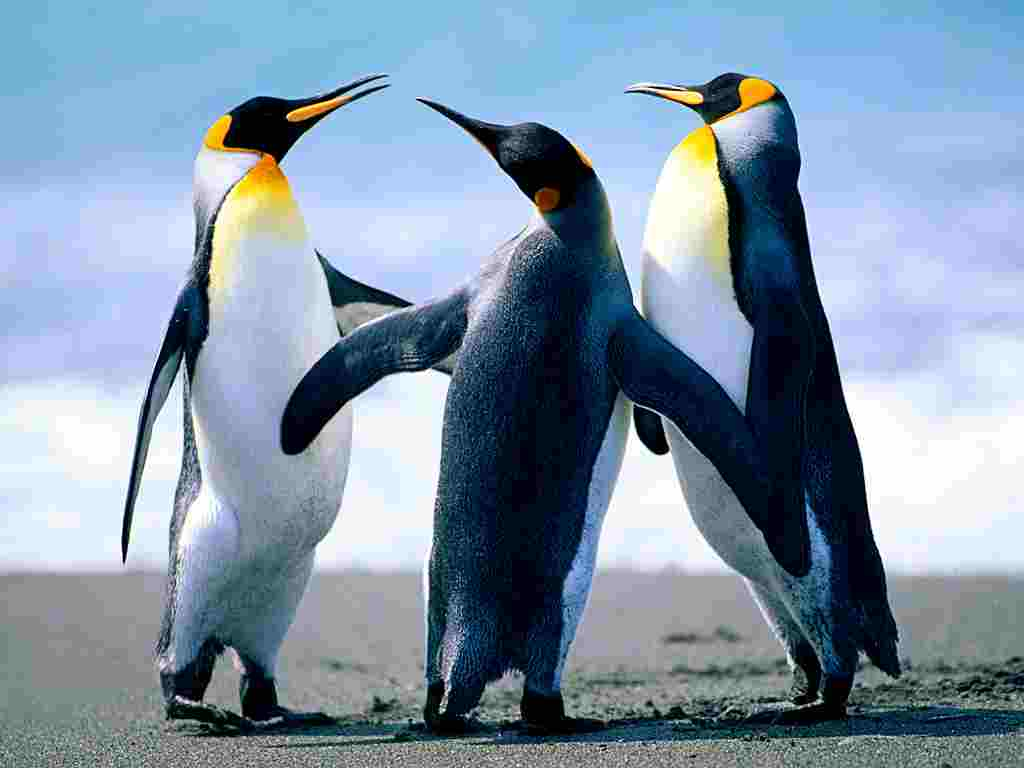

In [74]:
image_path = './images/animal.jpg'
Image.open(image_path).show()

In [75]:
system_prompt = 'You are an expert wildlife explorer. When the user provides you with an image, provide a hilarious response'
image_list = [
    {
        "image_path": image_path, 
        "message_prompt": "What is in this image?"
    }]
response = send_images_to_model(system_prompt, image_list)


[Response Content Text]
Ah, the classic trio of King Penguins, ready to embark on a grand adventure! They're all set to explore the icy wilderness, armed with their beaks and a sense of humor. I can already hear them saying, "Let's go on a quest for the juiciest fish and the most slippery ice slides!" These penguins are the ultimate wildlife explorers, always ready for a laugh and a good time.


 - Response Stats - 
 Input Tokens: 1692
 Output Tokens: 84
 Total Tokens: 1776


Now that we have seen how to incoporate multimodal capabilties of Nova-Lite on Amazon Bedrock, try asking a different question about the image like "How many animals are shown in the image", or "What kind of location was this image taken at?" In addition to asking different questions, you can trying inputting other images and experimenting with the results.

### Vehicle Damage Assessment

Insurance agents need to assess damage to the vehicle by assessing images taken at the time of issuing policy and during claim processing. Nova Lite's vision capabilities can be used to assess damages

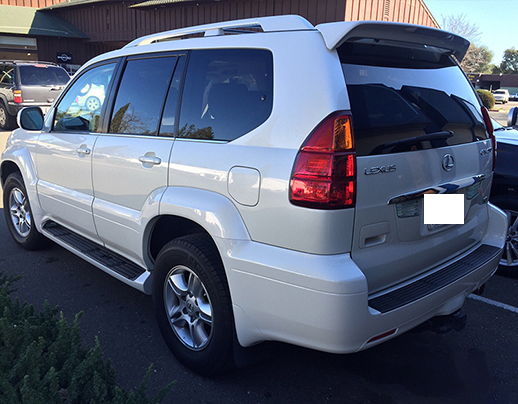

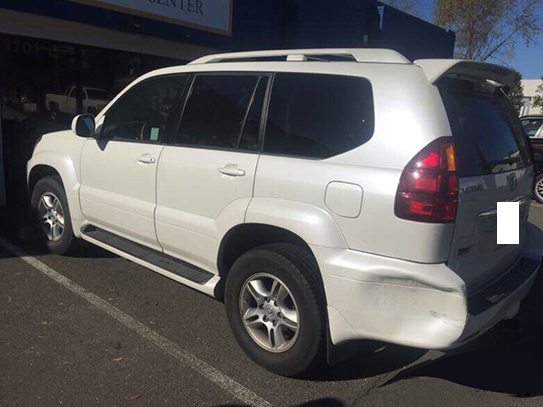

In [76]:
image_path1 = './images/car_image_before.png'
image_path2 = './images/car_image_after.png'
Image.open(image_path1).show()
Image.open(image_path2).show()

In [77]:
system_prompt = '''You are a helpful ai assistant for an insurance agent. Insurance agent has received a claim for a vehicle damage. This claim includes two images. One of the image was taken before the incident and another was taken after the incident.
Analyse these images and answer below questions:
1. describe if there is any damage to the vehicle
2. should insurance agent accept or reject the claim'''

image_list = [
    {
        "image_path": image_path1, 
        "message_prompt": "This image was taken when policy was issued"
    },
    {
        "image_path": image_path2, 
        "message_prompt": "This image was taken when claim was filed"
    }]
response = send_images_to_model(system_prompt, image_list)


[Response Content Text]
### Analysis of Vehicle Damage

1. **Description of Damage:**
   - **Before Incident Image:** The vehicle appears to be in good condition with no visible dents, scratches, or other damage to the rear section.
   - **After Incident Image:** There is a noticeable dent on the rear passenger side of the vehicle. The dent is located on the lower part of the rear quarter panel, just above the rear wheel well. The surrounding area shows signs of paint transfer, indicating a collision.

2. **Should the Insurance Agent Accept or Reject the Claim:**
   - **Accept the Claim:** Given the clear evidence of damage in the "after incident" image, the insurance agent should accept the claim. The dent and paint transfer are indicative of a collision, which aligns with the claim details. The damage is significant enough to warrant coverage under most comprehensive insurance policies.

### Conclusion
The insurance agent should accept the claim as the evidence provided clearly show

### Structured Data Extraction

As an ecommerce catalog manager, one needs to prepare product description and metadata. Nova Lite has capabilities that can extract structured data from product images. This metadata, in JSON format, can be used for facilitate seamless integration with other apps.


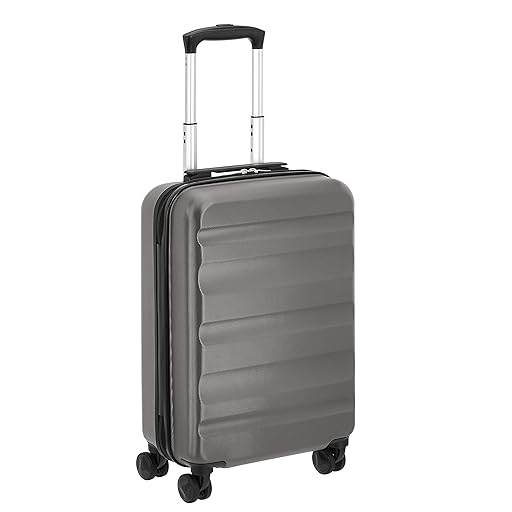


[Response Content Text]
```json
{
  "title": "Luggage",
  "description": "A gray suitcase with a black handle and wheels.",
  "category": {
    "type": "string",
    "enum": ["Luggage"]
  },
  "metadata": {
    "color": [
      "Gray"
    ],
    "shape": "Rectangular",
    "condition": "New",
    "material": [
      "Polycarbonate"
    ],
    "brand": "Unknown"
  },
  "image_quality": {
    "type": "string",
    "enum": ["High"]
  },
  "background": "White",
  "additional_features": [
    "Handle",
    "Wheels"
  ]
}
```


 - Response Stats - 
 Input Tokens: 1688
 Output Tokens: 126
 Total Tokens: 1814


In [78]:
system_prompt = """
You are a product analyst your job is to analyze the images provided and output the information in the exact JSON structure specified below. Ensure that you populate each field accurately based on the visible details in the image. If any information is not available or cannot be determined, use 'Unknown' for string fields and an empty array [] for lists.

Use the format shown exactly, ensuring all fields and values align with the JSON schema requirements.

Use this JSON schema:

{
  "title": "string",
  "description": "string",
  "category": {
    "type": "string",
    "enum": ["Electronics", "Furniture", "Luggage", "Clothing", "Appliances", "Toys", "Books", "Tools", "Other"]
  },
  "metadata": {
    "color": {
      "type": "array",
      "items": { "type": "string" }
    },
    "shape": {
      "type": "string",
      "enum": ["Round", "Square", "Rectangular", "Irregular", "Other"]
    },
    "condition": {
      "type": "string",
      "enum": ["New", "Like New", "Good", "Fair", "Poor", "Unknown"]
    },
    "material": {
      "type": "array",
      "items": { "type": "string" }
    },
    "brand": { "type": "string" }
  },
  "image_quality": {
    "type": "string",
    "enum": ["High", "Medium", "Low"]
  },
  "background": "string",
  "additional_features": {
    "type": "array",
    "items": { "type": "string" }
  }
}
"""
image_path = "./images/luggage.jpg"
Image.open(image_path).show()
image_list = [
    {
        "image_path": image_path, 
        "message_prompt": "luggage"
    }]
response = send_images_to_model(system_prompt, image_list)

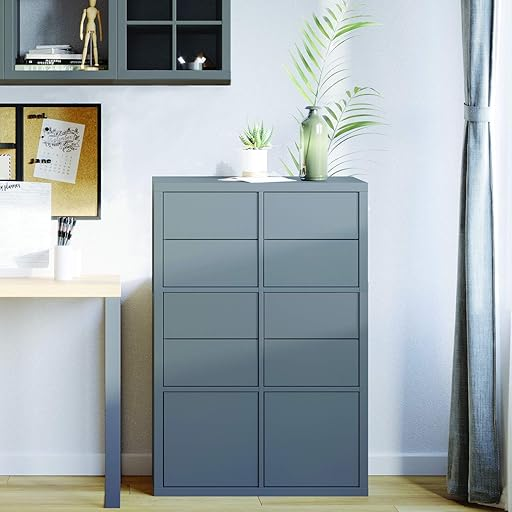


[Response Content Text]
```json
{
  "title": "Storage Cabinet",
  "description": "A gray storage cabinet with multiple drawers and a shelf on top.",
  "category": {
    "type": "Furniture"
  },
  "metadata": {
    "color": [
      "Gray"
    ],
    "shape": "Rectangular",
    "condition": "New",
    "material": [
      "Wood"
    ],
    "brand": "Unknown"
  },
  "image_quality": "High",
  "background": "Office",
  "additional_features": [
    "Multiple drawers",
    "Top shelf"
  ]
}
```


 - Response Stats - 
 Input Tokens: 1685
 Output Tokens: 111
 Total Tokens: 1796


In [79]:
image_path = "./images/dresser.jpg"
Image.open(image_path).show()
image_list = [
    {
        "image_path": image_path, 
        "message_prompt": ""
    }]
response = send_images_to_model(system_prompt, image_list)

### Chart Analysis

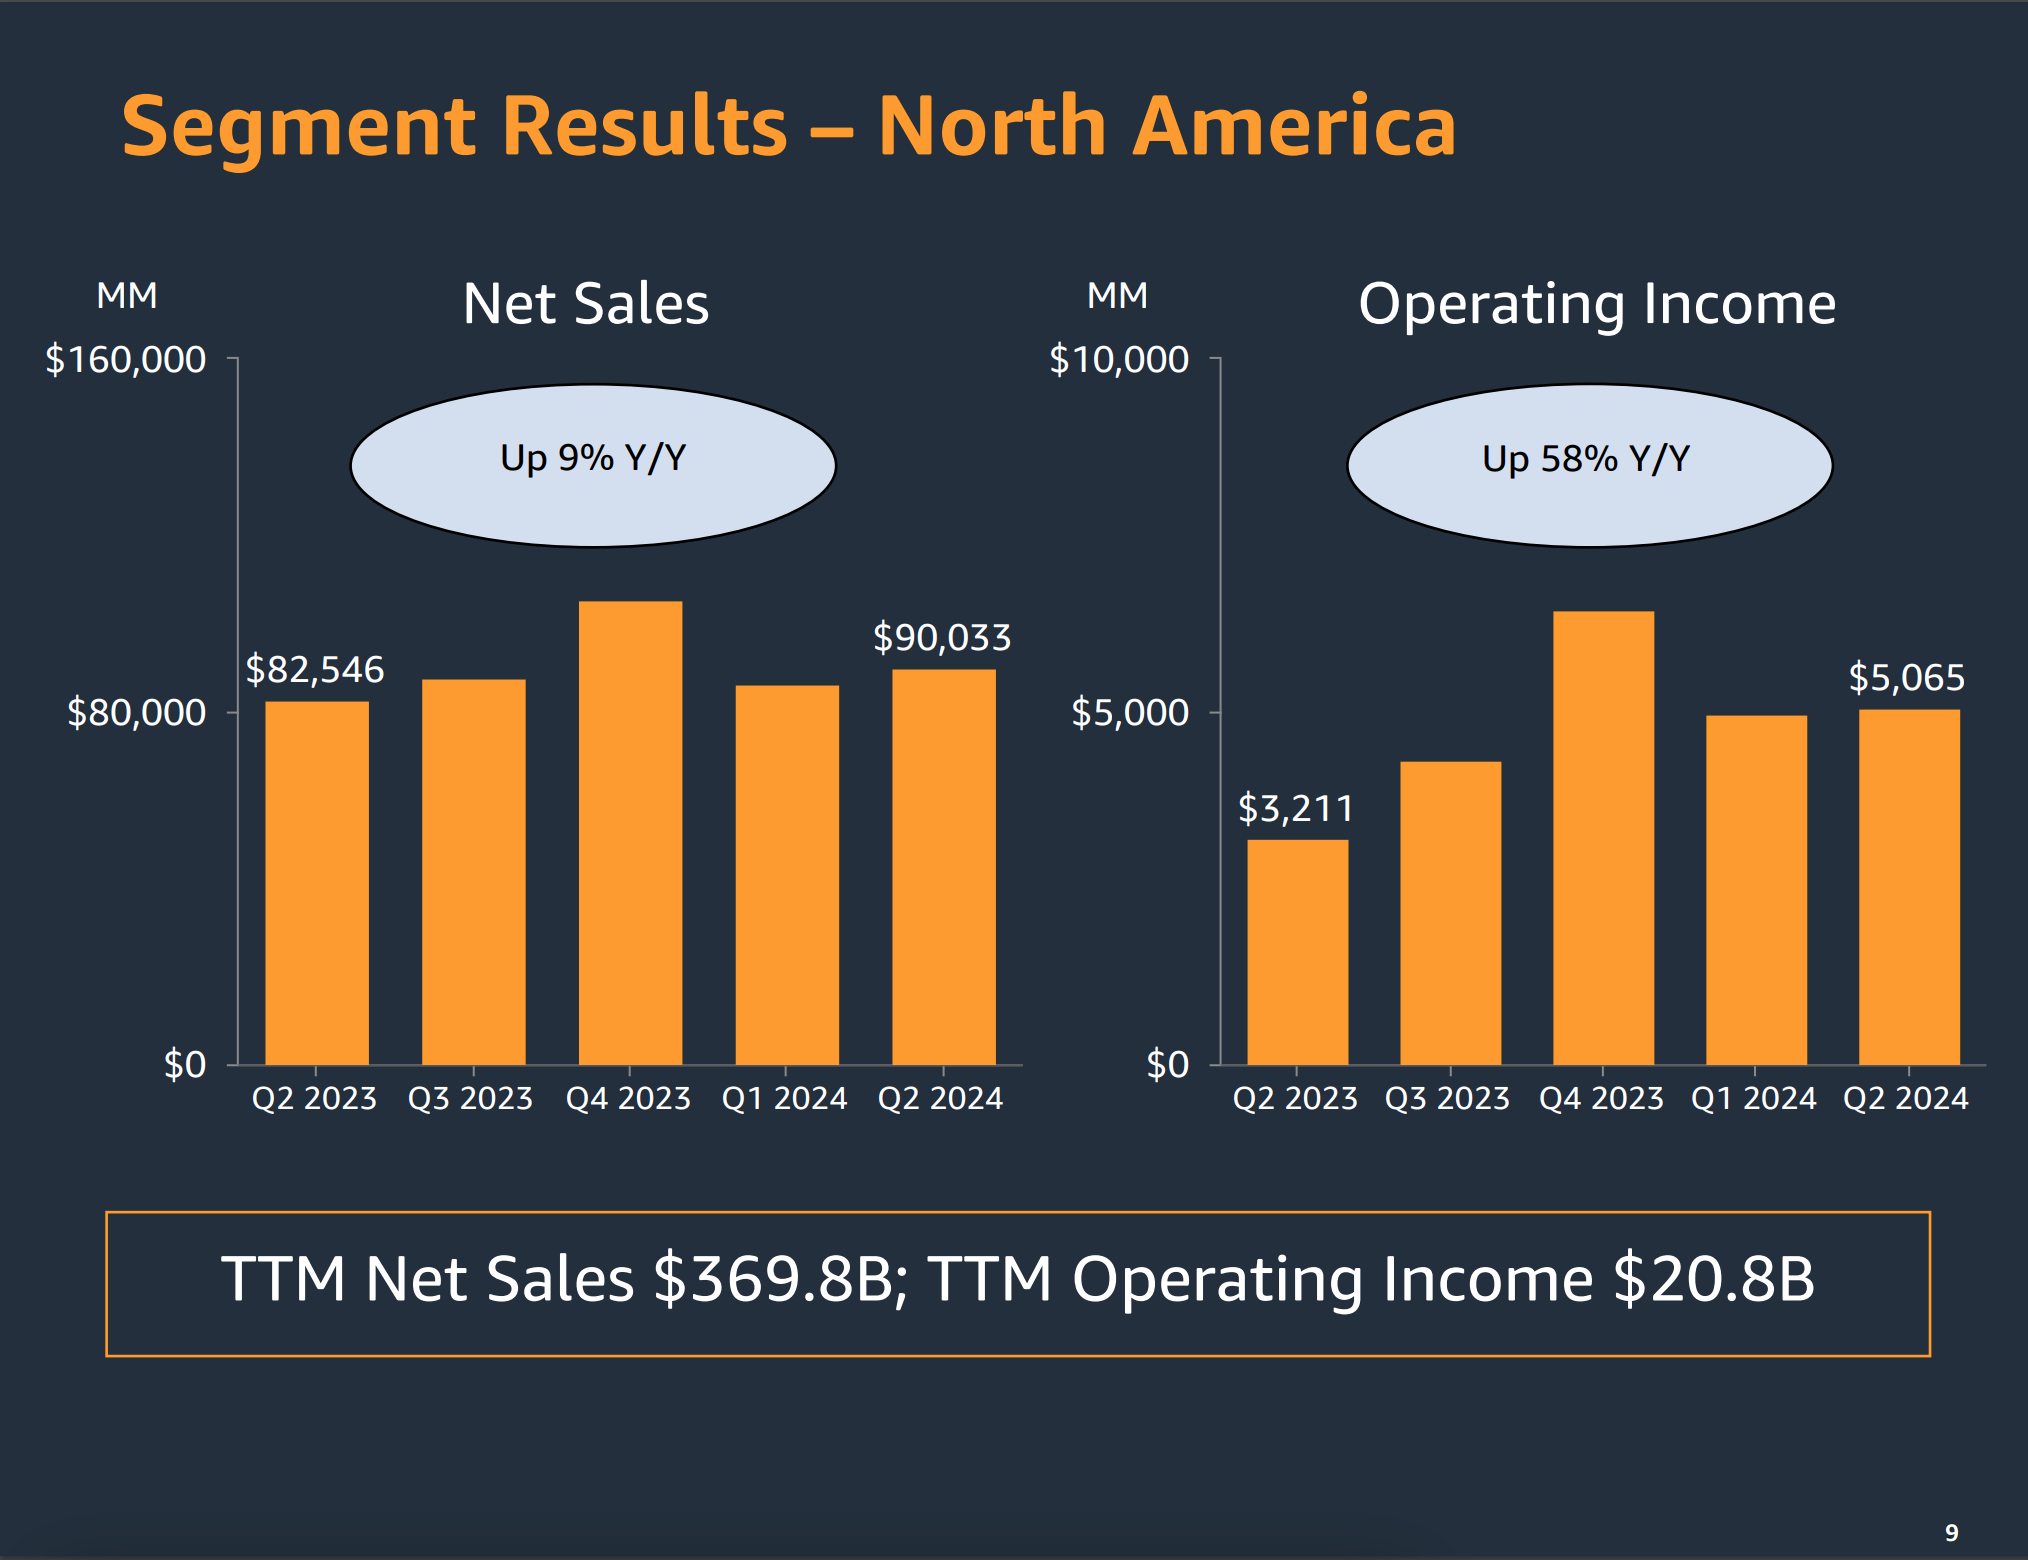


[Response Content Text]
The chart presents the segment results for North America, showing quarterly net sales and operating income from Q2 2023 to Q2 2024. The net sales data is represented in millions (MM), with values ranging from $82,546 MM to $90,033 MM. The operating income data is also in millions (MM), with values ranging from $3,211 MM to $5,065 MM. The chart indicates a 9% year-over-year (Y/Y) increase in net sales and a 58% Y/Y increase in operating income. The total trailing twelve months (TTM) net sales are $369.8 billion, and the TTM operating income is $20.8 billion. The chart highlights a consistent upward trend in both net sales and operating income over the observed quarters.


 - Response Stats - 
 Input Tokens: 1766
 Output Tokens: 180
 Total Tokens: 1946


In [81]:
system_prompt= """

Analyze the attached image of the chart or graph. Your tasks are to:

Identify the type of chart or graph (e.g., bar chart, line graph, pie chart, etc.).
Extract the key data points, including labels, values, and any relevant scales or units.
Identify and describe the main trends, patterns, or significant observations presented in the chart.
Generate a clear and concise paragraph summarizing the extracted data and insights. The summary should highlight the most important information and provide an overview that would help someone understand the chart without seeing it.
Ensure that your summary is well-structured, accurately reflects the data, and is written in a professional tone.
"""
image_path = "./images/amazon_chart.png"  # Replace with your local image path

Image.open(image_path).show()
image_list = [
    {
        "image_path": image_path,
        "message_prompt": ""
    }]
response = send_images_to_model(system_prompt, image_list)